In [ ]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from torchvision import transforms
import jax
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_dir = '/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/vit/'

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [ ]:
test_data=torch.load(drive_dir+"vit_test_1_95/"+"test_loader.pth")

In [ ]:
img_size = 250
feature_extractor = AutoFeatureExtractor.from_pretrained("25khattab/vit_test_1_95")
model = AutoModelForImageClassification.from_pretrained("25khattab/vit_test_1_95")
path = drive_dir

In [ ]:
from sklearn.metrics import confusion_matrix
preds=[]
labels=[]

test_data_iter=iter(test_data)
while True:
  try:
    test_batch = next(test_data_iter)
    outputs = model(**test_batch)
    logits = outputs.logits
    predicted_label =  outputs.logits.sigmoid().argmax(-1)
    for i in range(len(predicted_label)):
      pred=0 if predicted_label[i]==0 else 1
      preds.append(pred)
      lab=0 if test_batch["labels"][i]==0 else 1
      labels.append(lab)
  except StopIteration:
     break

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", xlabel="Prediction", ylabel="True"):
  conf_matrix = confusion_matrix(y_true, y_pred)
  names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  percents = ["{0:.3%}".format(num) for num in conf_matrix.flatten()/np.sum(conf_matrix)]
  labels = []
  for i in range(conf_matrix.shape[0]):
    labels.append([])
    for j in range(conf_matrix.shape[1]):
      labels[-1].append(f"{names[2*i+j]}\n{conf_matrix[i, j]}\n{percents[2*i+j]}")
  sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return conf_matrix

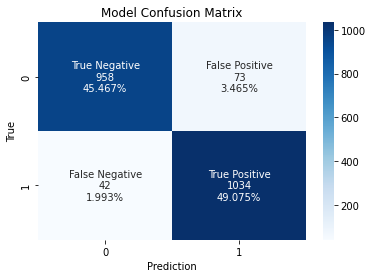

In [ ]:
cm=plot_confusion_matrix(labels, preds, "Model Confusion Matrix")

In [ ]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Sensitivity	Specificity	PPV	NPV	AUC	F1".split()
evaluations_test = {metric: {"model":None} for metric in eval_metrics}
tn=cm[0][0]
tp=cm[1][1]
fp=cm[0][1]
fn=cm[1][0]
acc=np.sum(np.diag(cm)/np.sum(cm))
sensitivity=tp/(tp+fn)
precision=tp/(tp+fp)
specificity=tn/(tn+fp)
ppv = tp / (tp + tp + 1e-100)
npv = tn / (tn + fn + 1e-100)
auc_value = roc_auc_score(labels, preds)
f1_score =  tp/(tp + 0.5 * (fp + fn) + 1e-100)

In [ ]:
evaluations_test["TP"]["model"] = tp
evaluations_test["TN"]["model"] = tn
evaluations_test["FP"]["model"] = fp
evaluations_test["FN"]["model"] = fn
evaluations_test["Accuracy"]["model"] = acc
evaluations_test["Sensitivity"]["model"] = sensitivity
evaluations_test["Specificity"]["model"] = specificity
evaluations_test["PPV"]["model"] = ppv
evaluations_test["NPV"]["model"] = npv
evaluations_test["AUC"]["model"] = auc_value
evaluations_test["F1"]["model"] = f1_score
evaluations_val = pd.DataFrame(evaluations_test)
display(evaluations_val)

,TP,TN,FP,FN,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC,F1
model,1034,958,73,42,0.94542,0.960967,0.929195,0.5,0.958,0.945081,0.94732


In [ ]:
# from sklearn.metrics import confusion_matrix
# from tqdm import tqdm

# preds=[]
# labels=[]
# for img,label in tqdm(zip(val_x_files,val_y),total=val_x_files.shape[0]):
#   # print(img,label)
#   try:
#       # img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
#       resized_arr = cv2.resize(img, (img_size, img_size))
#       plt.imshow(resized_arr)
#       inputs=feature_extractor(np.array(resized_arr), return_tensors="pt")
#       outputs = model(**inputs)
#       logits = outputs.logits
#       predicted_label = logits.argmax(-1).item()
#       pred=1 if predicted_label==0 else 0
#       preds.append(pred)
#       labels.append(label)
    
#   except Exception as e:
#       print(e)

# print(confusion_matrix(labels,preds))

In [ ]:
# for img in sorted(os.listdir(path), key = lambda x: (len (x), x)):
#   try:
#       img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
#       resized_arr = cv2.resize(img_arr, (img_size, img_size))
#       plt.imshow(resized_arr)
#       inputs=feature_extractor(np.array(resized_arr), return_tensors="pt")
#       outputs = model(**inputs)
#       logits = outputs.logits
#       predicted_label = logits.argmax(-1).item()
#       predict=model.config.id2label[predicted_label]
#       print(img,predict)
#       img2=os.path.splitext(img)[0]
#       with open(os.path.join(drive2_dir,'isbi_valid.predict'), 'a') as f:
#             if predict=="LABEL_0":
#               f.write("0\n")
#             else:
#               f.write("1\n")     
#   except Exception as e:
#       print(e)